<a href="https://colab.research.google.com/github/NajwaaAzzahra/Machine_Learning/blob/main/Pertemuan%2010/Jobsheet_RNN_Praktikum_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Najwa Azzahra
#TI-3C/19
#2241720139

**Jobsheet Recurrent Neural Network**

In [4]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

# Setup input pipeline

In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"Though I can't claim to be a comic book fanatic, I have read my share, so I guess I'm part of the audience of this film, and I wasn't disappointed. It does run out of steam near the end, it's almost overflowing with ideas, and it seems like Lena Olin, one of my favorite actresses, was left on the cutting room floor. Also, a little of Hank Azaria's Blue Raja can go a long way. Still, it's easy to forgive all of these faults when you have a film which is this much fun. All the actors seem to be having a blast with their roles, especially William H. Macy as the straight-arrow Shoveler, and Janeane Garofalo as The Bowler. And unlike some, I found the design of the city to make the joke even funnier. I also liked how disco was the music of choice of the bad guys; somehow, it seemed appropriate."
 b"She is such an extraordinary singer, who cares about anything else!!!! That final scene is one of the best moments in all of show biz - bar none!! I'm glad she kept the camera on herse

#Buat Teks Encoder

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[149,  10, 175, ...,   0,   0,   0],
       [ 55,   7, 136, ...,   0,   0,   0],
       [ 10,  63, 492, ...,   0,   0,   0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Though I can't claim to be a comic book fanatic, I have read my share, so I guess I'm part of the audience of this film, and I wasn't disappointed. It does run out of steam near the end, it's almost overflowing with ideas, and it seems like Lena Olin, one of my favorite actresses, was left on the cutting room floor. Also, a little of Hank Azaria's Blue Raja can go a long way. Still, it's easy to forgive all of these faults when you have a film which is this much fun. All the actors seem to be having a blast with their roles, especially William H. Macy as the straight-arrow Shoveler, and Janeane Garofalo as The Bowler. And unlike some, I found the design of the city to make the joke even funnier. I also liked how disco was the music of choice of the bad guys; somehow, it seemed appropriate."
Round-trip:  though i cant [UNK] to be a comic book [UNK] i have read my [UNK] so i guess im part of the audience of this film and i wasnt disappointed it does run out of [UNK] near the

#Buat Model

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[-0.00169805]


In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[-0.00169804]


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Train Model

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 635s 2s/step - accuracy: 0.5154 - loss: 0.6806 - val_accuracy: 0.7297 - val_loss: 0.6203
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.7730 - loss: 0.4672 - val_accuracy: 0.8120 - val_loss: 0.3682
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.8479 - loss: 0.3520 - val_accuracy: 0.8146 - val_loss: 0.4759
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.8523 - loss: 0.3434 - val_accuracy: 0.8573 - val_loss: 0.3332
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.8644 - loss: 0.3205 - val_accuracy: 0.8583 - val_loss: 0.3294
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 628s 2s/step - accuracy: 0.8651 - loss: 0.3118 - val_accuracy: 0.8229 - val_loss: 0.3837
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 674s 2s/step - accuracy: 0.8643 - loss: 0.3136 - val_accuracy: 0.8542 - val_loss: 0.3831
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.8679 - loss: 0.3091 - val_accu

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 138s 353ms/step - accuracy: 0.8619 - loss: 0.3128
Test Loss: 0.31271758675575256
Test Accuracy: 0.8608800172805786


(0.0, 0.6525849089026451)

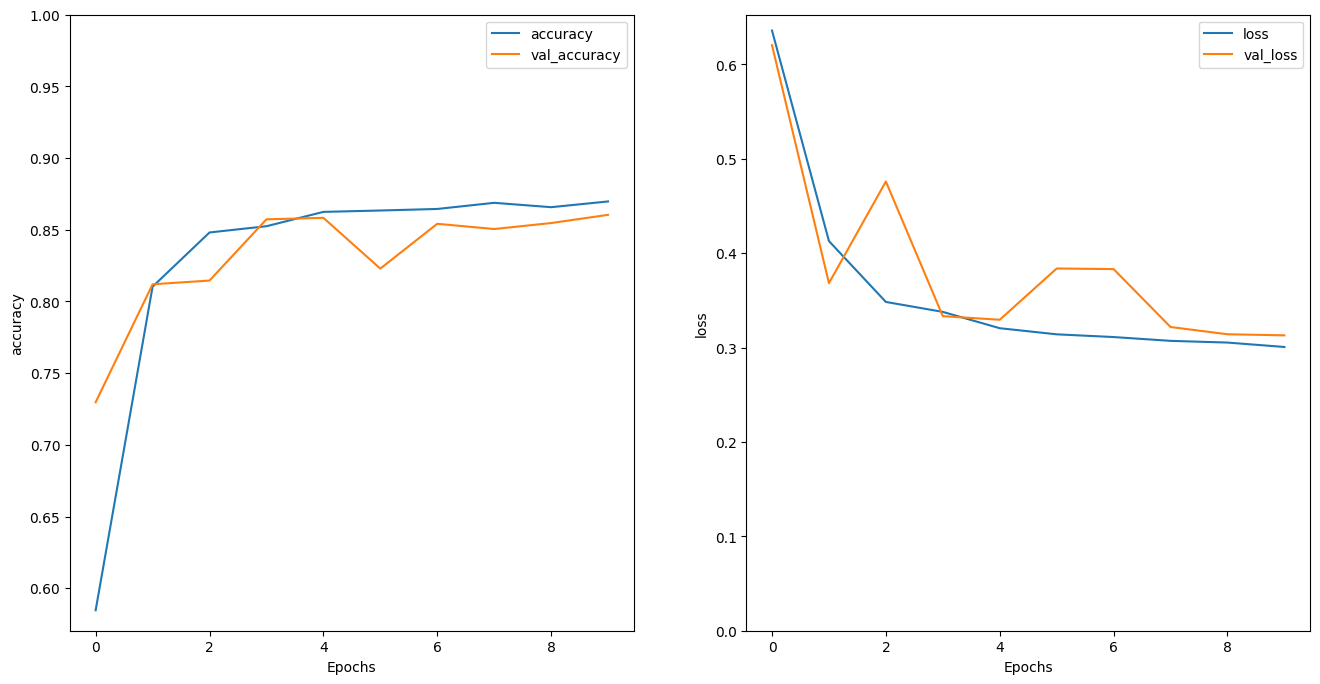

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#Stack two or more LSTM layers

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1235s 3s/step - accuracy: 0.5131 - loss: 0.6804 - val_accuracy: 0.8000 - val_loss: 0.4262
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1207s 3s/step - accuracy: 0.8218 - loss: 0.4031 - val_accuracy: 0.8562 - val_loss: 0.3550
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1212s 3s/step - accuracy: 0.8573 - loss: 0.3358 - val_accuracy: 0.8724 - val_loss: 0.3107
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1231s 3s/step - accuracy: 0.8608 - loss: 0.3228 - val_accuracy: 0.8536 - val_loss: 0.3382
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1217s 3s/step - accuracy: 0.8589 - loss: 0.3224 - val_accuracy: 0.8562 - val_loss: 0.3223
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1194s 3s/step - accuracy: 0.8621 - loss: 0.3130 - val_accuracy: 0.8573 - val_loss: 0.3250
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1199s 3s/step - accuracy: 0.8701 - loss: 0.3022 - val_accuracy: 0.8672 - val_loss: 0.3067
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1228s 3s/step - accuracy: 0.8755 - loss: 0.2967 - 

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 261s 667ms/step - accuracy: 0.8620 - loss: 0.3189
Test Loss: 0.3180345296859741
Test Accuracy: 0.8608400225639343


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 254s 651ms/step - accuracy: 0.8620 - loss: 0.3189
Test Loss: 0.3180345296859741
Test Accuracy: 0.8608400225639343


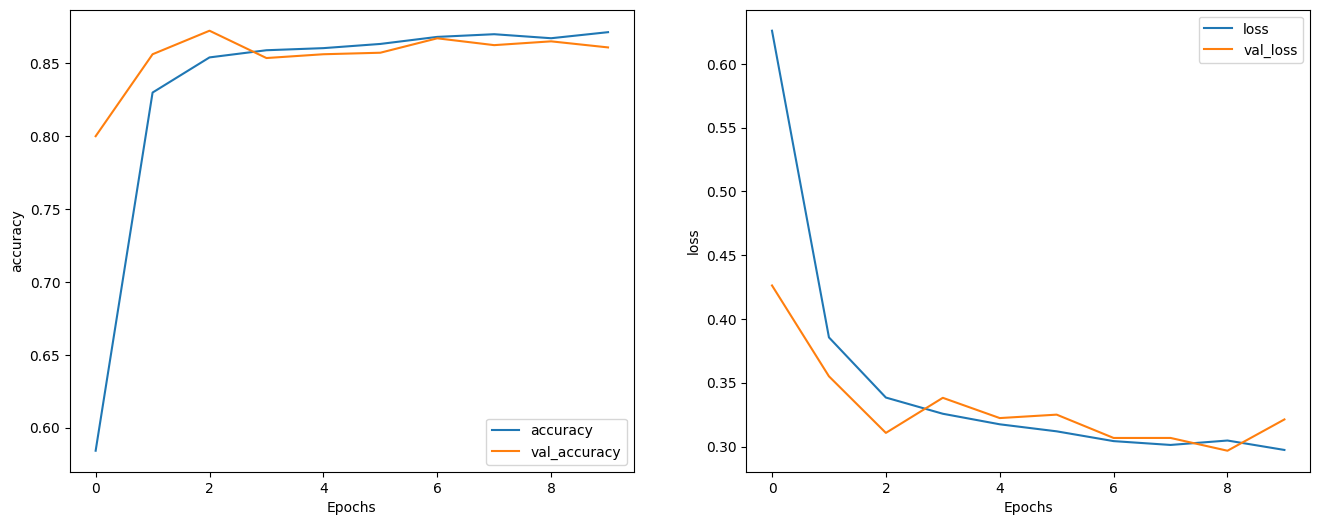

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')